# [How to get your API key](https://docs.google.com/presentation/d/1ptFrSvLMUxx9YDE7TzSexE0GQj-mSANOusBDgKo7jBs/edit?usp=sharing) (page 11-33)

In [38]:
import os

# Don't forget to upload your JSON file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "{YOUR_JSON_PATH}"

In [39]:
!pip install --upgrade google-cloud-vision
!pip install Pillow

# Label images

In [40]:
from google.cloud import vision

def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the Web."""
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.label_detection(image=image)
    labels = response.label_annotations
    return [label.description for label in labels]

# Test with a sample image
sample_image_uri = "https://wallpapercave.com/wp/wp3608722.jpg"  # Replace with any public image URL
labels = detect_labels_uri(sample_image_uri)
print(labels)

['Skyscraper', 'Building', 'Sky', 'Daytime', 'Photograph', 'Light', 'Tower', 'Nature', 'World', 'Dusk']


The sample image

<div align="center">
  <img
    width="640"
    src="https://wallpapercave.com/wp/wp3608722.jpg"
  >
</div>

# Optical Character Recognition (OCR)

In [14]:
def detect_text_uri(uri):
    """Detects text in the file located in Google Cloud Storage or on the Web."""

    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print("Texts:")

    for text in texts:
        print(f'\n"{text.description}"')

        vertices = [
            f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
        ]

        print("bounds: {}".format(",".join(vertices)))

    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )
    return texts

The sample image

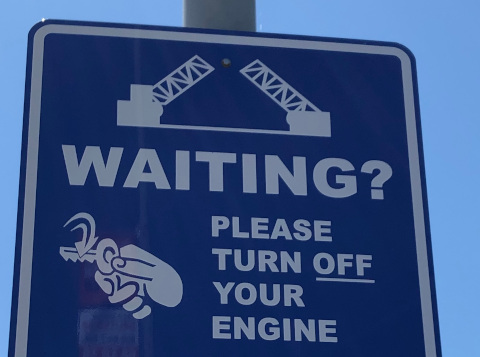

In [16]:
sample_image_ocr = "gs://cloud-samples-data/vision/ocr/sign.jpg"
text = detect_text_uri(sample_image_ocr)

Texts:

"WAITING?
PLEASE
TURN OFF
YOUR
ENGINE"
bounds: (328,823),(2237,823),(2237,1961),(328,1961)

"WAITING"
bounds: (338,823),(2046,896),(2036,1136),(328,1064)

"?"
bounds: (2065,897),(2237,904),(2227,1144),(2055,1137)

"PLEASE"
bounds: (1210,1230),(1901,1258),(1897,1377),(1205,1349)

"TURN"
bounds: (1217,1420),(1708,1438),(1703,1562),(1212,1544)

"OFF"
bounds: (1784,1441),(2127,1454),(2122,1578),(1779,1565)

"YOUR"
bounds: (1217,1614),(1739,1628),(1736,1750),(1214,1736)

"ENGINE"
bounds: (1211,1806),(1926,1825),(1922,1951),(1208,1933)


In [13]:
!gsutil cp -r "gs://cloud-samples-data/vision/ocr/sign.jpg"  sample.jpg

Copying gs://cloud-samples-data/vision/ocr/sign.jpg...
/ [1 files][849.6 KiB/849.6 KiB]                                                
Operation completed over 1 objects/849.6 KiB.                                    


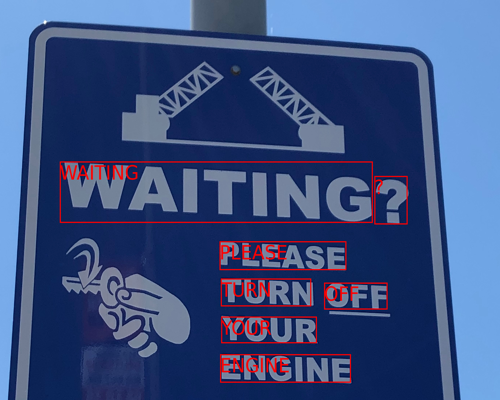

In [31]:
# Visualization
from PIL import Image,ImageDraw,ImageFont
import os
import cv2

font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
font = ImageFont.truetype(font_path, size=100)
image = Image.open("sample.jpg")
draw = ImageDraw.Draw(image)


for t in text[1:]:
    x = [vertex.x for vertex in t.bounding_poly.vertices]
    y = [vertex.y for vertex in t.bounding_poly.vertices]
    xmin, ymin, xmax, ymax = min(x), min(y), max(x), max(y)
    label = t.description
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=6)
    draw.text((xmin, ymin), f"{label}", fill="red", font=font)
newsize = (500, 400)
im = image.resize(newsize)
im

# Sentiment analyzing (need to enable Cloud Natural Language API)

In [43]:
from google.cloud import language_v2


def sample_analyze_sentiment(text_content: str = "I am so happy and joyful.") -> None:
    """
    Analyzes Sentiment in a string.

    Args:
      text_content: The text content to analyze.
    """

    client = language_v2.LanguageServiceClient()

    # text_content = 'I am so happy and joyful.'

    # Available types: PLAIN_TEXT, HTML
    document_type_in_plain_text = language_v2.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language_code = "en"
    document = {
        "content": text_content,
        "type_": document_type_in_plain_text,
        "language_code": language_code,
    }

    # Available values: NONE, UTF8, UTF16, UTF32
    # See https://cloud.google.com/natural-language/docs/reference/rest/v2/EncodingType.
    encoding_type = language_v2.EncodingType.UTF8

    response = client.analyze_sentiment(
        request={"document": document, "encoding_type": encoding_type}
    )
    # Get overall sentiment of the input document
    print(f"Document sentiment score: {response.document_sentiment.score}")
    print(f"Document sentiment magnitude: {response.document_sentiment.magnitude}")
    # Get sentiment for all sentences in the document
    for sentence in response.sentences:
        print(f"Sentence text: {sentence.text.content}")
        print(f"Sentence sentiment score: {sentence.sentiment.score}")
        print(f"Sentence sentiment magnitude: {sentence.sentiment.magnitude}")

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(f"Language of the text: {response.language_code}")


In [44]:
# Positive
# Magnitude: Intensity of emotion in text
sample_analyze_sentiment("I am so happy and joyful.")

Document sentiment score: 0.9259999990463257
Document sentiment magnitude: 0.9760000109672546
Sentence text: I am so happy and joyful.
Sentence sentiment score: 0.9269999861717224
Sentence sentiment magnitude: 0.9760000109672546
Language of the text: en


In [37]:
# Negative
sample_analyze_sentiment("I’m not into veggies, so why are my friends all about those salad spots?")

Document sentiment score: -0.6000000238418579
Document sentiment magnitude: 0.7279999852180481
Sentence text: I’m not into veggies, so why are my friends all about those salad spots?
Sentence sentiment score: -0.6000000238418579
Sentence sentiment magnitude: 0.7289999723434448
Language of the text: en


In [36]:
# Neutral
sample_analyze_sentiment("I wake up at 8 AM.")

Document sentiment score: 0.017999999225139618
Document sentiment magnitude: 0.07500000298023224
Sentence text: I wake up at 8 AM
Sentence sentiment score: 0.01899999938905239
Sentence sentiment magnitude: 0.07500000298023224
Language of the text: en


In [45]:
# 2 sentence
sample_analyze_sentiment("I am so happy and joyful. I wake up at 8 AM.")

Document sentiment score: 0.47200000286102295
Document sentiment magnitude: 1.034000039100647
Sentence text: I am so happy and joyful.
Sentence sentiment score: 0.9259999990463257
Sentence sentiment magnitude: 0.9760000109672546
Sentence text: I wake up at 8 AM.
Sentence sentiment score: 0.01899999938905239
Sentence sentiment magnitude: 0.05900000035762787
Language of the text: en
